# Experiment on Breast Cancer Classification

Based on the results and the network presented in this [paper](https://arxiv.org/abs/1811.04241), I conducted an experiment on breast cancer classification.<br>
I trained different *KNN* classifiers and deep models using the *BreakHis* dataset.

To achieve this, I used well-known deep-learning frameworks for [*python*](https://www.python.org/) such as:

- [TensorFlow](https://www.tensorflow.org/)
- [Keras](https://www.tensorflow.org/api_docs/python/tf/keras)
- [scikit-learn](https://scikit-learn.org/)

The goal of this work is to compare the performance of 4 different deep models that should perform well with images:<br> BreastNet, VGG16, VGG19, Inception-ResNet.<br>
In details, the *Inception-ResNet* shares some observations made to build the network *IRRCNN* presented by the main paper.
While in the last three cases the neural network implementation is directly provided by *Keras*, the former was presented in 2019, through the following [paper](https://www.sciencedirect.com/science/article/pii/S0378437119319995), and was implemented in *python* by the same researchers (see [*breastnet.py*](https://github.com/dariocurr/dl_project/blob/main/breastnet.py)).<br>

Because of the small number of images contained in the dataset (7909 images), I used data augmentation, that is a regularization method, before feeding the networks.<br>
Also, as optimizer I used *SGD* with 0.9 *momentum* and *decay*, since from the papers I read it seems to be a well-performing optimizer and kind of a standard for this type of data. 

<br>

NB: in order to replicate this experiment you need to download the [*BreakHis* dataset](https://web.inf.ufpr.br/vri/databases/breast-cancer-histopathological-database-breakhis/), extract it in a folder named *data*.

<br>

<br>

Sections:

1. Preprocessing


2. KNN classification


3. Data augmentation


4. Deep models

    1. Hyperparameters
    2. [BreastNet](https://www.sciencedirect.com/science/article/pii/S0378437119319995)
    3. [VGG16](https://arxiv.org/abs/1409.1556)
    4. [VGG19](https://arxiv.org/abs/1409.1556)
    5. [Inception-ResNet](https://arxiv.org/abs/1602.07261)


5. Comparison of results


6. Conclusion and further experiments


In [1]:
import breastnet

import os
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sn

from tqdm import tqdm
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, classification_report, confusion_matrix, roc_curve

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.applications import VGG16, VGG19, InceptionResNetV2
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator

warnings.filterwarnings('ignore')

We define some functions that we are going to use during the execution.

In [2]:
def plot_stats(stats, model_names, labels, y_label, n_classes):
    width = 0.1
    x = [i for i in range(n_classes)]
    fig, ax = plt.subplots(figsize=(2.5 * n_classes, 5))
    ax.set_ylabel(y_label)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    y_ticks = [0.20, 0.40, 0.60, 0.80, 1]
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([str(int(y_tick * 100)) + "%" for y_tick in y_ticks])
    ax.set_ylim([0, 1.07])
    for i in range(len(model_names)):
        ax.bar(
            [clazz + ((i - (len(labels) / 2)) * width) for clazz in x],
            stats[i],
            width,
            label=model_names[i]
        )
    print()
    ax.legend()
    plt.show()

In [3]:
def plot_image(x, label):
    plt.imshow(x)
    plt.xlabel(label)
    plt.grid(False)

In [4]:
def plot_prediction_array(prediction, predicted_class, true_class):
    plt.grid(False)
    plt.xticks(range(len(prediction)))
    plt.yticks([])
    plot = plt.bar(range(len(prediction)), prediction, color="#777777")
    plot[predicted_class].set_color('red')
    plot[true_class].set_color('blue')

In [5]:
def plot_results(indices, x_test, y_test, y_predicted, encoder):
    plt.figure(figsize=(10, 5))
    for i in range(4):
        image_index = indices[i]
        prediction = y_predicted[image_index]
        plt.subplot(2, 4, 2 * i + 1)
        percentage = round(max(prediction) * 100, 2)
        predicted_class = np.argmax(y_predicted[image_index])
        true_class = np.argmax(y_test[image_index])
        predicted_class_label = encoder.inverse_transform([predicted_class])[0]
        true_class_label = encoder.inverse_transform([true_class])[0]
        x_label = str(predicted_class_label) + " " + str(percentage) + "%\n(" + str(true_class_label) + ")"
        plot_image(x_test[image_index], x_label)
        plt.xticks([])
        plt.yticks([])
        plt.subplot(2, 4, 2 * i + 2)
        plot_prediction_array(y_predicted[image_index], predicted_class, true_class)

In [6]:
def plot_roc_curve(y_true, y_probabilities):
    plt.figure(figsize=(6, 6))
    false_positive_rate, true_positive_rate, _ = roc_curve(y_true, y_probabilities) 
    area_under_curve = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend()
    plt.show()

In [7]:
def plot_confusion_matrix(y_true, y_predicted, labels):
    size = len(labels) * 2
    plt.figure(figsize=(size, size))
    sn.heatmap(
        data = confusion_matrix(y_true, y_predicted),
        cmap = "YlGnBu",
        fmt= 'g',
        annot = True,
        xticklabels = labels,
        yticklabels = labels
    )
    plt.xlabel("predicted") 
    plt.ylabel("true")
    plt.show()

In [8]:
def compute_stats(report, n_classes):
    accuracy = report["accuracy"]
    recalls = []
    precisions = []
    for clazz in range(n_classes):
        recalls.append(report[str(clazz)]["recall"]) 
        precisions.append(report[str(clazz)]["precision"]) 
    return accuracy, recalls, precisions

We define some variables that we are going to use during the execution.

In [9]:
base_data_path =  './data/BreaKHis_v1/histology_slides/breast'
magnifications = ['40X', '100X', '200X', '400X']
classes = ['benign', 'malignant']
sub_classes = {
    'benign': ['adenosis', 'fibroadenoma', 'phyllodes_tumor', 'tubular_adenoma'],
    'malignant': ['ductal_carcinoma', 'lobular_carcinoma', 'mucinous_carcinoma', 'papillary_carcinoma']
}

keys = ["binary", "benign", "malignant"]
labels = [classes, sub_classes["benign"], sub_classes["malignant"]]
n_classes = [2, 4, 4]

test_size = 0.3
random_state = 42

## 1. Preprocessing

We create a dataset containing all information.

In [10]:
dataset = pd.DataFrame()
for clazz in tqdm(classes):
    for sub_clazz in sub_classes[clazz]:
        path = os.path.join(base_data_path, clazz, "SOB", sub_clazz)
        for id in os.listdir(path):
            for magnification in magnifications:
                path_to_files = os.path.join(path, id, magnification)
                for file_name in os.listdir(path_to_files):
                    dataset = dataset.append({
                        'id': id,
                        'path': os.path.join(path_to_files, file_name),
                        'magnification': magnification,
                        'type': sub_clazz,
                        'lesion': clazz
                }, ignore_index=True)

dataset

100%|██████████| 2/2 [00:16<00:00,  8.45s/it]


,id,lesion,magnification,path,type
0,SOB_B_A_14-22549AB,benign,40X,./data/BreaKHis_v1/histology_slides/breast/ben...,adenosis
1,SOB_B_A_14-22549AB,benign,40X,./data/BreaKHis_v1/histology_slides/breast/ben...,adenosis
2,SOB_B_A_14-22549AB,benign,40X,./data/BreaKHis_v1/histology_slides/breast/ben...,adenosis
3,SOB_B_A_14-22549AB,benign,40X,./data/BreaKHis_v1/histology_slides/breast/ben...,adenosis
4,SOB_B_A_14-22549AB,benign,40X,./data/BreaKHis_v1/histology_slides/breast/ben...,adenosis
...,...,...,...,...,...
7904,SOB_M_PC_14-15687B,malignant,400X,./data/BreaKHis_v1/histology_slides/breast/mal...,papillary_carcinoma
7905,SOB_M_PC_14-15687B,malignant,400X,./data/BreaKHis_v1/histology_slides/breast/mal...,papillary_carcinoma
7906,SOB_M_PC_14-15687B,malignant,400X,./data/BreaKHis_v1/histology_slides/breast/mal...,papillary_carcinoma
7907,SOB_M_PC_14-15687B,malignant,400X,./data/BreaKHis_v1/histology_slides/breast/mal...,papillary_carcinoma


We create 2 subdatasets, one for benign samples and one for malignant ones, in order to perform *lesion-type* classification.

In [11]:
benign_dataset = dataset[dataset["type"].isin(sub_classes["benign"])]
malignant_dataset = dataset[dataset["type"].isin(sub_classes["malignant"])]

We read the images contained in the dataset as follows:

1. Load the images as arrays using methods defined in *keras.prepocessing.image*

2. Resize them keeping proportions: from *700x460* to *256x168* using *nearest* interpolation.<br>
We need to resize the images because of limited resources

3. Scale their values to a range from 0 to 1 before feeding the network

Then the shape of multidimensional array containing all the images, that is *x*, is (7909, 168, 256, 3).

In [12]:
n_samples = (len(dataset), )
image_size = (168, 256, 3)
x = np.empty(n_samples + image_size, dtype=np.float32)
for i, path in tqdm(enumerate(dataset["path"])):
    image = load_img(path, target_size=image_size)
    x[i, :, :, :] = img_to_array(image) / 255.0

7909it [01:30, 87.76it/s] 


In order to classify the images, we need to encode their labels (*lesion* and *type*). To achieve this goal we use the *sklearn.preprocessing.LabelEncoder*.

Since lesion can be either *bening* or *malignant*, we are going to define a binary encoder.

Instead, we have 8 different types of lesions: 4 for the bening samples, 4 for the malignant ones.<br>
Then, to identify the type of the lesion we need to define two *LabelEncoder* more.

At the end in the *encoders* list we will have the:

1. lesion encoder
2. benign-type encoder
3. malignant-type encoder

In [13]:
encoders = []
for i in range(len(keys)):
    encoder = LabelEncoder()
    encoder.fit(labels[i])
    encoders.append(encoder)

We create the datasets for all differents kinds of classification we are going to perform.

In *xs* and *ys* list, in the same way as the encoders, we have the train and the test sets for the:

1. lesion classifier
2. benign-type classifier
3. malignant-type classifier


In [14]:
xs = [x, x[benign_dataset.index], x[malignant_dataset.index]]
y_datasets = [dataset["lesion"], benign_dataset["type"], malignant_dataset["type"]]
ys = []
for i in range(len(keys)):
    ys.append(encoders[i].transform(y_datasets[i]))

We split the our dataset in training and test set: we use 70% of the samples for training and 30% for testing as specified in the paper.

In order to perform different types of classification using the same dataset, we split them specifying the *random_state* (details [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)) to keep the corrispondence.

In [15]:
x_trains, x_tests, y_trains, y_tests = [], [], [], []

for i in range(len(keys)):
    x_train, x_test, y_train, y_test = train_test_split(
        xs[i],
        ys[i],
        test_size=test_size,
        shuffle=True,
        random_state=random_state
    )
    x_trains.append(x_train)
    x_tests.append(x_test)
    y_trains.append(y_train)
    y_tests.append(y_test)

## 2. KNN classifier

First of all, we perform a "easy" classifications using *KNN* classifiers.

To do so, we need to flatten our arrays using *numpy*.

In [16]:
flattened_x_trains, flattened_x_tests = [], []

for i in range(3):
    # flatten x_train
    flattened_x_train = np.empty((len(x_trains[i]), np.prod(image_size)))
    for j, image in enumerate(x_trains[i]):
        flattened_x_train[j][:] = image.flatten()
    flattened_x_trains.append(flattened_x_train)
    # flatten x_test
    flattened_x_test = np.empty((len(x_tests[i]), np.prod(image_size)))
    for j, image in enumerate(x_tests[i]):
        flattened_x_test[j][:] = image.flatten()
    flattened_x_tests.append(flattened_x_test)

We define a dictionary containing dictionaries to keep all the reports.

In [17]:
knn_reports = {}
for key in keys:
    knn_reports[key] = {}

Then we perform the classification using *sklearn.neighbors.KNeighborsClassifier*.

NB: it wasn't possible to perform KNN classification with data augmentation due to limited resources.

In [18]:
for k in tqdm(range(1, 31)):
    for i in range(len(keys)):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(flattened_x_trains[i], y_trains[i])
        knn_reports[keys[i]][k] = classification_report(
            y_tests[i],
            knn.predict(flattened_x_tests[i]),
            output_dict=True
        )

print()
for i in range(len(keys)):
    best_k = max(knn_reports[keys[i]], key = lambda k: knn_reports[keys[i]][k]["accuracy"])
    knn_reports[keys[i]]["best_k"] = best_k
    best_accuracy, best_recalls, best_precisions = compute_stats(knn_reports[keys[i]][best_k], n_classes[i])
    knn_reports[keys[i]]["best_accuracy"] = best_accuracy
    knn_reports[keys[i]]["best_recalls"] = best_recalls
    knn_reports[keys[i]]["best_precisions"] = best_precisions
    print()
    print("Best k for " + keys[i] + " classification: " + str(best_k))
    print(keys[i].capitalize() + " knn's accuracy: " + str(best_accuracy))

100%|██████████| 30/30 [32:34<00:00, 65.14s/it]

Best k for binary classification: 18
Binary knn's accuracy: 0.8154235145385588

Best k for benign classification: 5
Benign knn's accuracy: 0.3333333333333333

Best k for malignant classification: 24
Malignant knn's accuracy: 0.6623695518723143



As can be seen by the results above, the *KNN* classifier doesn't seem to perform well in this experiment, at least without data augmentation.

## 3. Data augmentation

As done in the experiment discussed in the paper, we perform data augmentation. To achieve this goal we use the image generator defined by *keras.preprocessing.image*.

The parameters that we choose for the image generator are the same as those defined in the paper. <br>
On the other hand, the number of samples generated is about 25% of the 166.068 used in the paper due to limited resources.

In [19]:
image_generator = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

Since we are gonna to use a *keras model* we need to convert our labels in one-hot encoding.<br>
To do so, we use the method *to_categorial* defined in *keras.utils* and we split again the dataset as done before.

In [20]:
y_trains_categorical = []
y_tests_categorical = []

for i in range(len(keys)):
    _, _, y_train_categorical, y_test_categorical = train_test_split(
        xs[i],
        to_categorical(ys[i], n_classes[i]),
        test_size=test_size,
        shuffle=True,
        random_state=random_state
    )
    y_trains_categorical.append(y_train_categorical)
    y_tests_categorical.append(y_test_categorical)

Once all the sets are ready, we can augment our train set.<br>
The new train set is a dictionary containing, for each kind of classification, the datasets: *x_train* and *y_train*.

In [21]:
n_iterations = 6
batch_sizes = [len(x_train) for x_train in x_trains]

augmented_dataset = {}
for i in range(len(keys)):
    augmented_dataset[keys[i]] = {}
    augmented_dataset[keys[i]]["x_train"] = np.empty(
        (batch_sizes[i] * n_iterations, ) + image_size,
        dtype=np.float32
    )
    augmented_dataset[keys[i]]["y_train"] = np.empty(
        (batch_sizes[i] * n_iterations, n_classes[i]),
        dtype=np.int8
    )

for i in tqdm(range(len(keys))):
    augmented_dataset[keys[i]]["x_train"][:batch_sizes[i]] = x_trains[i]
    augmented_dataset[keys[i]]["y_train"][:batch_sizes[i]] = y_trains_categorical[i]
    iterator = image_generator.flow(x_trains[i], y_trains_categorical[i], batch_size=batch_sizes[i], shuffle=True)
    for j in range(1, n_iterations):
        images = iterator.next()
        start_index = batch_sizes[i] * j
        for k in range(batch_sizes[i]):
            augmented_dataset[keys[i]]["x_train"][start_index + k] = images[0][k]
            augmented_dataset[keys[i]]["y_train"][start_index + k] = images[1][k]

100%|██████████| 3/3 [07:06<00:00, 142.23s/it]


We render 30 random images after data augmentation using *matplotlib*.

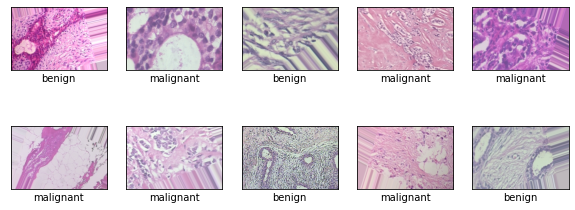

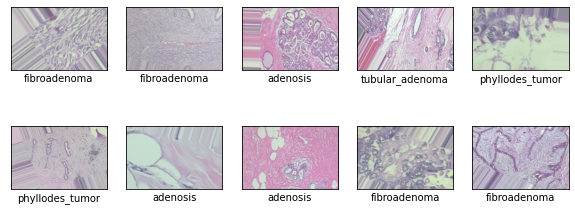

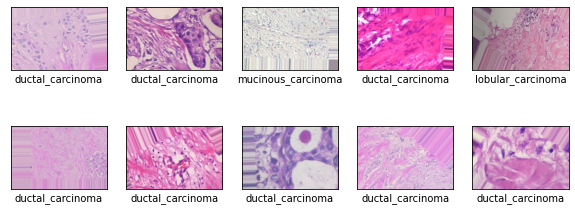

In [22]:
n_images = 10
for i, key in enumerate(keys):
	print("\n")
	random_indices = [random.randint(0, len(augmented_dataset[key]["x_train"])) for _ in range(n_images)]
	images = augmented_dataset[key]["x_train"][random_indices, :, :, :]
	images_labels = augmented_dataset[key]["y_train"][random_indices]
	plt.figure(figsize=(10, 4))
	for j in range(n_images):
		plt.subplot(2, 5, j + 1)
		plot_image(images[j], encoders[i].inverse_transform(np.array([np.argmax(images_labels[j])]))[0])
		plt.xticks([])
		plt.yticks([])
	plt.show()

## 4. Deep models

We create a dataset to store the result of deep models.

In [23]:
deep_models = ["breastnet", "vgg16", "vgg19", "inception-resnet"]
deep_models_results = {}
for i in range(len(keys)):
    deep_models_results[keys[i]] = {}
    deep_models_results[keys[i]]["y_true"] = y_tests[i]
    for deep_model in deep_models:
        deep_models_results[keys[i]][deep_model] = {}

### 1. Hyperparameters

As in the experiment discussed in the paper:
 - we set the number of epochs to 50

 - we use *SGD* as optimizer with *momentum* set to 0.9.<br>
 Hence, the update rule using momentum is: $velocity = momentum * velocity - ε * g$ &nbsp;&nbsp;&nbsp; => &nbsp;&nbsp;&nbsp; $w = w + velocity$
 
 - the learning rate *ε* is decreased by a factor of 10 after 50 epochs

Since additional information aren't provided in the paper:
- we set the batch size, that is number of images used to compute the gradient, to 64
- we use *cross entropy* as loss function
- we use the 10% of the train set as validation set

Then we set *steps_per_epoch = (len(x_train) - len(x_validation)) / batch_size*.<br>
This means that each epoch works on the whole training set, using *(len(x_train) - len(x_validation)) / batch_size* steps, processing *batch_size* images at each step.

Then total number of images processed during the training phase is: *(len(x_train) - len(x_validation)) \* number of epochs*.

In [24]:
loss_functions = ["binary_crossentropy", "categorical_crossentropy", "categorical_crossentropy"]
batch_size = 64
epochs = 50
validation_split = 0.1
train_split = (1 - validation_split)
steps_per_epoch, optimizers = [], []
for i in range(len(keys)):
    steps_per_epoch.append((len(augmented_dataset[keys[i]]["x_train"]) * train_split) / batch_size)
    learning_rate_scheduler = PolynomialDecay(
        initial_learning_rate=0.01,
        decay_steps=epochs*steps_per_epoch[i],
        end_learning_rate=0.001
    )
    optimizers.append(SGD(learning_rate=learning_rate_scheduler, momentum=0.9, name="SGD"))

### 2. BreastNet

<img src="img/breastnet_model.png" alt="BreastNet model" width="600"/>

BreastNet model consists of the following modules in general:


1. Convolutional block:<br>
These blocks consist of Conv2D, batch normalization and ReLU activation layers.<br>
The main purpose of these blocks is to extract relevant features from input tensors

<img src="img/breastnet_convolutional_block.png" alt="BreastNet convolutional block" width="400"/>


2. CBAM block:<br>
CBAM is an effective module for feed-forward CNN model.<br>
CBAM examines the feature map extracted from images at two dimensions: channel and spatial.<br>
Channel and spatial module focuses on ‘what’ and ‘where’ respectively.<br>
They contribute to the classification process by extracting more efficient features

<img src="img/breastnet_cbam_block.png" alt="BreastNet" width="400"/>

In order to collect spatial information, both the average and maximum pooling information are used together simultaneously.

<img src="img/breastnet_channel_attention_module.png" alt="BreastNet channel attention module" width="400"/>

The spatial module uses two outputs that are pooled along the channel axis and forward them to a convolution layer

<img src="img/breastnet_spatial_attention_module.png" alt="BreastNet spatial attention module" width="400"/>


3. Residual block:<br>
In a network with residual blocks, each layer feeds the next layer and initial layer connects the layers about two-three hops away with addition operation.<br>
When a sequential network is deep, the problem of vanishing/exploding gradients occurs.<br>
To reduce the negative results of this problem we used a residual block

<img src="img/breastnet_residual_block.png" alt="BreastNet residual block" width="400"/>


4. Hypercolumn technique:<br>
Hypercolumn at a pixel is the vector of activations of all CNN units above that pixel.<br>
Using this technique, spatial location information can be brought from earlier layers, and have a more accurate prediction result.<br>
Since CNN normally uses the output of the last layer as a feature representation, it does not use the features of the preceding layers. Therefore, hypercolumn in a pixel with the hypercolumn technique is the vector of all CNN units over that pixel.<br> In other words, it also includes the features of previous layers.<br>
This technique consists of UpSampling2D with bilinear interpolation and Concatenate layers.<br>
An UpSampling2D layer repeats the rows and columns of the data.<br>
A Concatenate layer concatenates a list of inputs.<br>


5. Dense block:<br>
These blocks consist of Dense, batch normalization and ReLU activation layers.<br>
The main purpose of these blocks is to extract relevant features from input tensors

<img src="img/breastnet_dense_block.png" alt="BreastNet dense block" width="400"/>

In [25]:
breastnet.BreastNet(image_size, n_classes=n_classes[0]).summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 168, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 168, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 168, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 168, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [26]:
model_name = deep_models[0]
print()
for i in range(len(keys)):
    model = breastnet.BreastNet(image_size, n_classes=n_classes[i])
    model.compile(loss=loss_functions[i], optimizer=optimizers[i], metrics=["accuracy"])
    print("Training " + keys[i] + " " + model_name + "...\n")
    model.fit(
        augmented_dataset[keys[i]]["x_train"],
        augmented_dataset[keys[i]]["y_train"],
        steps_per_epoch=steps_per_epoch[i],
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split
    )
    model.save("./models/" + keys[i] + "_" + model_name)
    # model = load_model("./models/" + keys[i] + "_" + model_name)
    print("\n\n")
    deep_models_results[keys[i]][model_name]["predictions"] = model.predict(x_tests[i])
    deep_models_results[keys[i]][model_name]["y_predicted"] = [
        np.argmax(array) for array in deep_models_results[keys[i]][model_name]["predictions"]
    ]
    report = classification_report(
        deep_models_results[keys[i]]["y_true"],
        deep_models_results[keys[i]][model_name]["y_predicted"],
        output_dict=True
    )
    accuracy, recalls, precisions = compute_stats(report, n_classes[i])
    deep_models_results[keys[i]][model_name]["accuracy"] = accuracy
    deep_models_results[keys[i]][model_name]["recalls"] = recalls
    deep_models_results[keys[i]][model_name]["precisions"] = precisions

We render the confusion matrix of each classification.


Binary model's accuracy: 0.9848293299620733



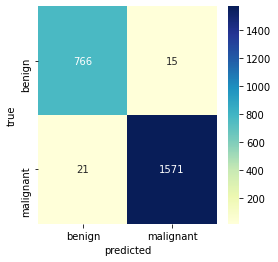




Benign model's accuracy: 0.9543010752688172



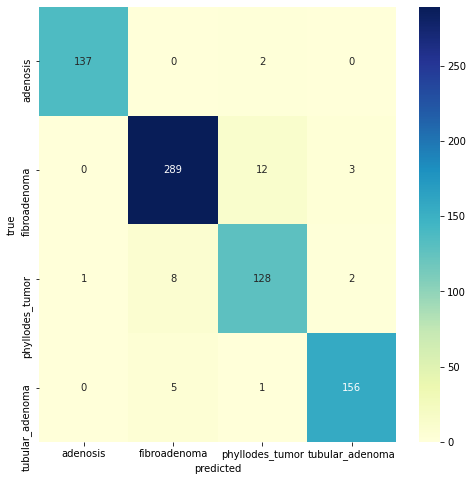




Malignant model's accuracy: 0.9220380601596071



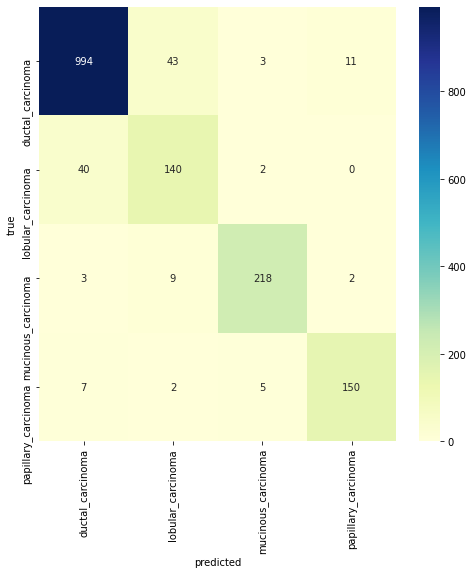

In [27]:
print()
for i in range(len(keys)):
    print(
        keys[i].capitalize() + " model's accuracy: " + str(deep_models_results[keys[i]][model_name]["accuracy"]),
        end="\n\n"
    )
    plot_confusion_matrix(
        deep_models_results[keys[i]]["y_true"],
        deep_models_results[keys[i]][model_name]["y_predicted"],
        labels[i]
    )
    print("\n\n")

We render the ROC curve for the lesion classification.

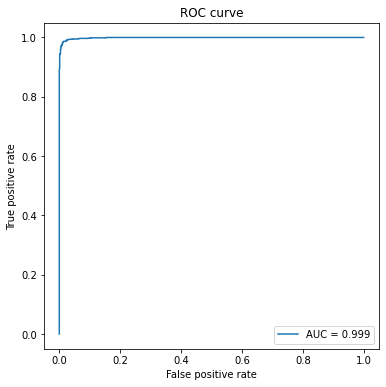

In [28]:
plot_roc_curve(
    deep_models_results["binary"]["y_true"],
    [np.max(array) for array in deep_models_results["binary"][model_name]["predictions"][:, 1]]
)

We render some lesion classifications and their prediction values.

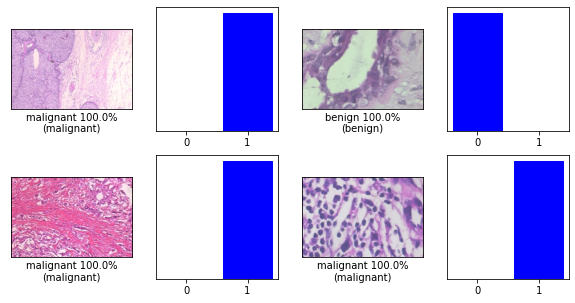

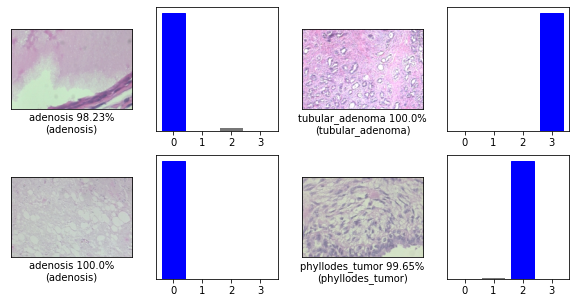

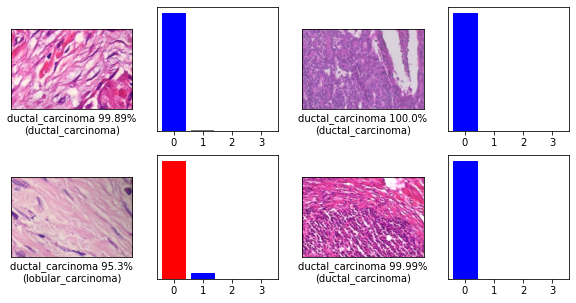

In [29]:
for i in range(len(keys)):
    plot_results(
        [random.randint(0, len(x_tests[i])) for _ in range(16)],
        x_tests[i],
        y_tests_categorical[i],
        deep_models_results[keys[i]][model_name]["predictions"],
        encoders[i]
    )

### 3. VGG16

![VGG 16](img/vgg16.png) 

VGG-16 consists of convolutional, pooling and fully connected layers. It contains a total of 21 layers.<br>
The most important feature of this architecture is having an increasing network structure.<br>
The filter size in the convolutional layer is 3 × 3.<br>
The final layers have FC layers used for feature extraction.<br>
In this architecture Softmax is used as the activation function of the last layer.

In [30]:
VGG16(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=image_size,
    pooling='max',
    classes=n_classes[0],
    classifier_activation='softmax'
).summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 168, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 168, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 168, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 84, 128, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 84, 128, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 84, 128, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 42, 64, 128)       0     

In [31]:
model_name = deep_models[1]
print()
for i in range(len(keys)):
    model = VGG16(
        include_top=True,
        weights=None,
        input_tensor=None,
        input_shape=image_size,
        pooling='max',
        classes=n_classes[i],
        classifier_activation='softmax'
    )
    model.compile(loss=loss_functions[i], optimizer=optimizers[i], metrics=["accuracy"])
    print("Training " + keys[i] + " " + model_name + "...\n")
    model.fit(
        augmented_dataset[keys[i]]["x_train"],
        augmented_dataset[keys[i]]["y_train"],
        steps_per_epoch=steps_per_epoch[i],
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split
    )
    model.save("./models/" + keys[i] + "_" + model_name)
    # model = load_model("./models/" + keys[i] + "_" + model_name)
    print("\n\n")
    deep_models_results[keys[i]][model_name]["predictions"] = model.predict(x_tests[i])
    deep_models_results[keys[i]][model_name]["y_predicted"] = [
        np.argmax(array) for array in deep_models_results[keys[i]][model_name]["predictions"]
    ]
    report = classification_report(
        deep_models_results[keys[i]]["y_true"],
        deep_models_results[keys[i]][model_name]["y_predicted"],
        output_dict=True
    )
    accuracy, recalls, precisions = compute_stats(report, n_classes[i])
    deep_models_results[keys[i]][model_name]["accuracy"] = accuracy
    deep_models_results[keys[i]][model_name]["recalls"] = recalls
    deep_models_results[keys[i]][model_name]["precisions"] = precisions

### 4. VGG19

![VGG 19](img/vgg19.png) 

The VGG-19 consists of 24 layers: convolution layers, pool layers, and fully connected layers.<br>
The most important feature of this architecture is having an increasing network structure.<br>
The filter size in the convolutional layer is 3 × 3.<br>
The final layers have FC layers used for feature extraction.<br>
In this architecture Softmax is used as the activation function of the last layer.

In [32]:
VGG19(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=image_size,
    pooling='max',
    classes=n_classes[0],
    classifier_activation='softmax'
).summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 168, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 168, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 168, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 84, 128, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 84, 128, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 84, 128, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 42, 64, 128)       0     

In [33]:
model_name = deep_models[2]
print()
for i in range(len(keys)):
    model = VGG19(
        include_top=True,
        weights=None,
        input_tensor=None,
        input_shape=image_size,
        pooling='max',
        classes=n_classes[i],
        classifier_activation='softmax'
    )
    model.compile(loss=loss_functions[i], optimizer=optimizers[i], metrics=["accuracy"])
    print("Training " + keys[i] + " " + model_name + "...\n")
    model.fit(
        augmented_dataset[keys[i]]["x_train"],
        augmented_dataset[keys[i]]["y_train"],
        steps_per_epoch=steps_per_epoch[i],
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split
    )
    model.save("./models/" + keys[i] + "_" + model_name)
    # model = load_model("./models/" + keys[i] + "_" + model_name)
    print("\n\n")
    deep_models_results[keys[i]][model_name]["predictions"] = model.predict(x_tests[i])
    deep_models_results[keys[i]][model_name]["y_predicted"] = [
        np.argmax(array) for array in deep_models_results[keys[i]][model_name]["predictions"]
    ]
    report = classification_report(
        deep_models_results[keys[i]]["y_true"],
        deep_models_results[keys[i]][model_name]["y_predicted"],
        output_dict=True
    )
    accuracy, recalls, precisions = compute_stats(report, n_classes[i])
    deep_models_results[keys[i]][model_name]["accuracy"] = accuracy
    deep_models_results[keys[i]][model_name]["recalls"] = recalls
    deep_models_results[keys[i]][model_name]["precisions"] = precisions

### 5. Inception-ResNet

An *Inception* block is a block with an architectural design that consists of repeating components referred to as *Inception modules*.<br>

Inception blocks were developed because:

1. Highly performant deep neural networks need to be deep.

2. Convolutional neural networks benefit from extracting features at varying scales. Therefore multi-scale convolutional networks have the potential to learn more.

Then, Inception blocks make the network less deeper but wider and use convulutiona layer wiith different filters to extract more features.

NB: By omitting the batch-normalization on top of Inception-Residual layers, we are able to increase the overall number of Inception blocks substantially

![Inception-ResNet](img/inception-resnet_model.png)


1. Stem block

![Inception-ResNet stem block](img/inception-resnet_stem_block.png)


2. A block

![Inception-ResNet A block](img/inception-resnet_A_block.png)


3. Reduction A block

![Inception-ResNet reduction A block](img/inception-resnet_reduction_A_block.png)


4. B block

![Inception-ResNet B block](img/inception-resnet_B_block.png)


5. Reduction B block

![Inception-ResNet reduction B block](img/inception-resnet_reduction_B_block.png)


6. C block

![Inception-ResNet C block](img/inception-resnet_C_block.png)

In [34]:
InceptionResNetV2(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=image_size,
    pooling='max',
    classes=n_classes[0],
    classifier_activation='softmax'
).summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 168, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 83, 127, 32)  864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 83, 127, 32)  96          conv2d_10[0][0]                  
__________________________________________________________________________________________________
activation_8 (Activation)       (None, 83, 127, 32)  0           batch_normalization_10[0][0]     
________________________________________________________________________________

In [35]:
model_name = deep_models[3]
print()
for i in range(len(keys)):
    model = InceptionResNetV2(
        include_top=True,
        weights=None,
        input_tensor=None,
        input_shape=image_size,
        pooling='max',
        classes=n_classes[i],
        classifier_activation='softmax'
    )
    model.compile(loss=loss_functions[i], optimizer=optimizers[i], metrics=["accuracy"])
    print("Training " + keys[i] + " " + model_name + "...\n")
    model.fit(
        augmented_dataset[keys[i]]["x_train"],
        augmented_dataset[keys[i]]["y_train"],
        steps_per_epoch=steps_per_epoch[i],
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split
    )
    model.save("./models/" + keys[i] + "_" + model_name)
    # model = load_model("./models/" + keys[i] + "_" + model_name) 
    print("\n\n")
    deep_models_results[keys[i]][model_name]["predictions"] = model.predict(x_tests[i])
    deep_models_results[keys[i]][model_name]["y_predicted"] = [
        np.argmax(array) for array in deep_models_results[keys[i]][model_name]["predictions"]
    ]
    report = classification_report(
        deep_models_results[keys[i]]["y_true"],
        deep_models_results[keys[i]][model_name]["y_predicted"],
        output_dict=True
    )
    accuracy, recalls, precisions = compute_stats(report, n_classes[i])
    deep_models_results[keys[i]][model_name]["accuracy"] = accuracy
    deep_models_results[keys[i]][model_name]["recalls"] = recalls
    deep_models_results[keys[i]][model_name]["precisions"] = precisions

## 5. Comparison of results

We render the recall and the precision of each class for each classifier.


Binary classification: 
Accuracy of the knn classifier: 0.8154235145385588
Accuracy of the breastnet classifier: 0.9848293299620733
Accuracy of the vgg16 classifier: 0.9178255372945638
Accuracy of the vgg19 classifier: 0.9136114622840287
Accuracy of the inception-resnet classifier: 0.9258322798145807



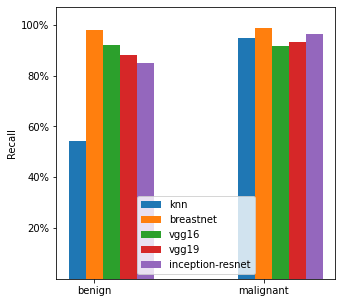

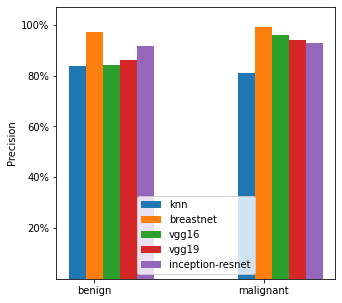




Benign classification: 
Accuracy of the knn classifier: 0.3333333333333333
Accuracy of the breastnet classifier: 0.9543010752688172
Accuracy of the vgg16 classifier: 0.5806451612903226
Accuracy of the vgg19 classifier: 0.6048387096774194
Accuracy of the inception-resnet classifier: 0.8655913978494624



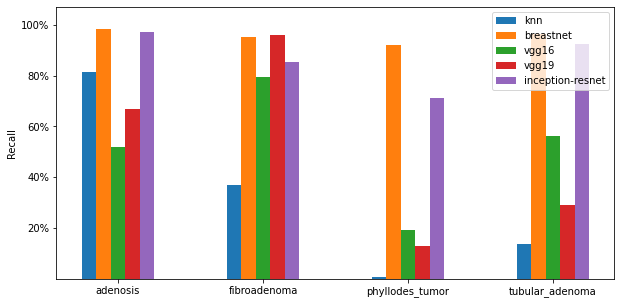

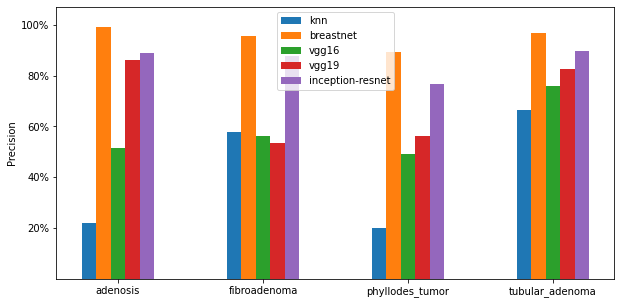




Malignant classification: 
Accuracy of the knn classifier: 0.6623695518723143
Accuracy of the breastnet classifier: 0.9220380601596071
Accuracy of the vgg16 classifier: 0.8354818907305095
Accuracy of the vgg19 classifier: 0.7759361571516268
Accuracy of the inception-resnet classifier: 0.9306322897483118



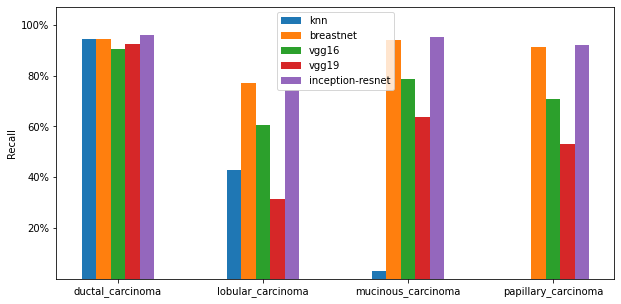

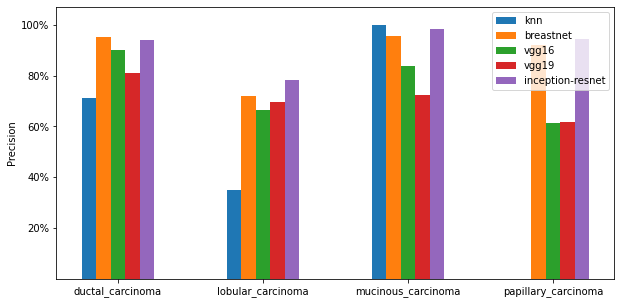

In [36]:
print()
for i in range(len(keys)):
    print(keys[i].capitalize() + " classification: ")
    print("Accuracy of the knn classifier: " + str(knn_reports[keys[i]]["best_accuracy"]))
    for deep_model in deep_models:
        print("Accuracy of the " + deep_model + " classifier: " + 
            str(deep_models_results[keys[i]][deep_model]["accuracy"])
        )
    recalls = [knn_reports[keys[i]]["best_recalls"]]
    recalls += [deep_models_results[keys[i]][deep_model]["recalls"] for deep_model in deep_models]
    plot_stats(
        recalls,
        ["knn"] + deep_models,
        labels[i],
        "Recall",
        n_classes[i]
    )
    print()
    precisions = [knn_reports[keys[i]]["best_precisions"]]
    precisions += [deep_models_results[keys[i]][deep_model]["precisions"] for deep_model in deep_models]
    plot_stats(
        precisions,
        ["knn"] + deep_models,
        labels[i],
        "Precision",
        n_classes[i]
    )
    print("\n\n")

## 6. Conclusion and further experiments

### Conclusion

1. Without any doubt, the best binary classifier is the *BreastNet*. <br>
In detail, the accuracy obtained is similar to that one obtained by researchers: 98.48% vs. 98.80%.


2. On the other and the results obtained by the BreastNet for *lesion-type* classification are quite different from the ones obtained by the researchers:

    - 95.43% vs 97.78% for *benign-type* classification
    - 92.20% vs 96.41% for *malignant-type* classification

    This could be caused by the different optimizer used (in the paper, the researchers used *Adam* with $β_1 = 0.9$, $β_2 = 0.999$, $decay = 0$) and by image resizing.


3. The *BreastNet* is also the best *benign-type* classifier (95.43%), whereas the best *malignant-type* classifier seems to be the *Inception-ResNet* (93.06%).


4. The *VGG16* and *VGG19* networks performs better than expected based on what is described [here](https://www.sciencedirect.com/science/article/pii/S0378437119319995):

    - 91.78% vs 83.13% for VGG16 binary classification
    - 91.36% vs 83.27% for VGG16 binary classification

    Probably, data augmentation helps these models.


5. The *Inception-ResNet* seems to be a good starting point for improvement as confirmed by the performances obtained with the *IRRCNN* network. 

<br>

### Possible further experiments

1. Run the whole notebook without image resizing
2. Run the whole notebook with the same data augmentation as defined in the paper (20 images for each image instead of 5)
3. Perform *KNN* classification with data augmentation
4. Change hyperparameters: number of epochs, batch size and optimizer
5. Extend the proposed models
6. Add different models